# Music Genre Classification via Clustering Methods

The following Sample Code is retrieved from STA142B Final Project, which focusing on clustering analysis and unsupervised learning, and will demonstrate techniques in audio feature engineering, assesing cluster performence, and parameter tuning.

In [12]:
"""
Attempt 1:
After researching for appropriate methods for feature engineering, I have decided to use a set of timbral texture 
features. These include: spectral centroid (which is a measure of the centre of gravity of the magnitude spectrum), 
spectral roll-off (which corresponds to the frequency below which there is 85% of the energy of the magnitude spectrum), 
spectral flux (which accounts for the energy difference between successive frames of the spectrogram), 
zero-crossing rate (ZCR), and MFCCs ,which are a very popular set of features based on the auditive human system 
that uses a Mel-frequency scale to group the frequency bins. 
"""
import librosa
import numpy as np
import scipy.stats as ss

def compute_ssd(x):
    mean_ = np.mean(x)
    median_ = np.median(x)
    var_ = np.var(x)
    skew_ = ss.skew(x, axis=None)
    kurt_ = ss.kurtosis(x, axis=None)
    min_ = np.amin(x)
    max_ = np.amax(x)
    return np.array([mean_, median_, var_, skew_, kurt_, min_, max_])

# function for feature extraction
def feature_extractor(x, sr, length):
    """
    Extracts the following features from a music signal `x` in a form of a vector:
        - SSD of spectral centroid
        - SSD of spectral roll-off
        - SSD of spectral flux
        - SSD of zero-crossing rate
        - SSD of Mel-Frequency Cepstral Coefficients (MFCCs)
        - RMS of spectogram
        - SSD of spectral bandwidth
        - SSD of spectral flatness
        - proportion of each of the 12 pitches in the signal (determined using chromagram)
        - tempo
    where SSD contains the following:
        - mean
        - median
        - variance
        - skewness
        - kurtosis
        - min value
        - max value
    """
    # pad signal
    y = librosa.util.pad_center(data=x, size=length)
    # spectral centroid
    sc = librosa.feature.spectral_centroid(y=y, sr=sr)
    # spectral roll-off
    sro = librosa.feature.spectral_rolloff(y=y, sr=sr)
    # spectral flux
    sf = librosa.onset.onset_strength(y=y, sr=sr)
    # zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    # SSD of mfcc
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    # RMS of spectogram
    S, _ = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rms(S=S)
    # spectral bandwidth
    sb = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    # spectral flatness
    sflat = librosa.feature.spectral_flatness(y=y)
    # pitch proportion through chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    pitch_sum = np.sum(chroma, axis=1)
    pitch_prop = pitch_sum/np.sum(pitch_sum)
    # tempo
    tmp = librosa.beat.tempo(y=y, sr=sr)
    # reshape features to 1D-vectors
    sc = sc.reshape(-1)
    sro = sro.reshape(-1)
    zcr = zcr.reshape(-1)
    rms = rms.reshape(-1)
    sb = sb.reshape(-1)
    sflat = sflat.reshape(-1)
    # concatenate all features
    zcr_ssd = compute_ssd(zcr)
    sc_ssd = compute_ssd(sc)
    sro_ssd = compute_ssd(sro)
    sf_ssd = compute_ssd(sf)
    mfcc_ssd = compute_ssd(mfcc)
    rms_ssd = compute_ssd(rms)
    sb_ssd = compute_ssd(sb)
    sflat_ssd = compute_ssd(sflat)
    features = np.hstack((sc_ssd, sro_ssd, sro_ssd, mfcc_ssd))
    return features

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# function to plot silhouette
def plot_silhouette(X, lab, ax):
    """
    Makes silhoutte plot given the data, labels, and plot axis
    """
    # get silhouette score
    score = sklearn.metrics.silhouette_score(X, lab)
    values = sklearn.metrics.silhouette_samples(X, lab)
    
    # make plot
    n_clusters = len(np.unique(lab))
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = values[lab == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_xlabel("silhouette coef")
    ax.set_ylabel("label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.5, 1] + [score])

In [15]:
import librosa
import os
import warnings
import numpy as np

warnings.filterwarnings(action="ignore")

# get file path and files
filepath = "./Sound Track Data - STA142B/data/"

# from exploratory data analysis, we find that:
# max data length is 661824 
# min data length is 660984
# sampling rate (sr) is the same for all files at 22050
# number of audio files is 90

# declare variable to store all data
X = np.zeros((90, 28))
length = 661824
sr = 22050

# store all music features in X
for i in range(90):
    file = "{0}.mp3".format(i)
    y,_ = librosa.load(os.path.join(filepath, file))
    X[i,:] = feature_extractor(y, sr, length)

In [16]:
from sklearn.preprocessing import StandardScaler

# standardize features
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# correlation matrix
S = np.corrcoef(Xs)

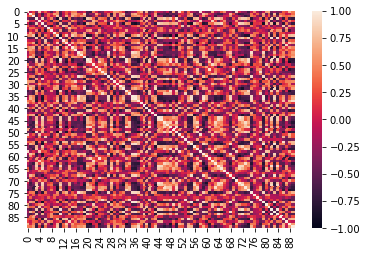

In [17]:
import seaborn as sns

# correlation matrix plot
sns.heatmap(S, vmin=-1, vmax=1);

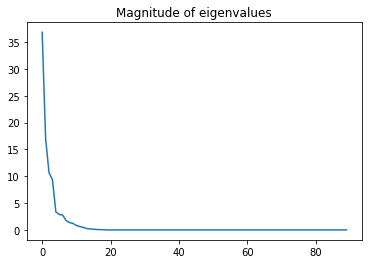

In [18]:
# spectral decomposition, S = P @ A @ P.T
A, P = np.linalg.eigh(S)
A = np.clip(A, a_min=0, a_max=None)  # clip negative eigenvalues (from machine error)

# order eigenvalues and eigenvectors by decreasing magnitude
order = np.argsort(-A)
A = A[order]
P = P[:,order]
plt.plot(A)
plt.title("Magnitude of eigenvalues");

In [19]:
# Q = P @ A^(1/2)
A2 = np.sqrt(A)
Q = P @ np.diag(A2)

# use top 15 eigenvalues for reconstruction
R = P[:,:15] @ np.diag(A2[:15])

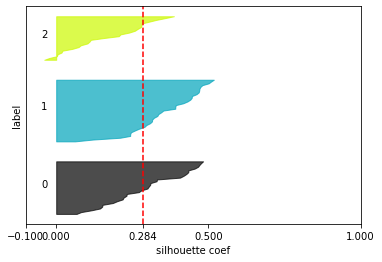

In [20]:
import sklearn.cluster

clustering = sklearn.cluster.KMeans(n_clusters=3)
lab = clustering.fit_predict(R)
fig, ax = plt.subplots(1,1)
plot_silhouette(R, lab, ax)

In [21]:
"""
Attempt 2:
Thinking from musical perspective, different genres use different instruments or sounds. Therefore, the frequencies
varies between different genres. So, I have decided to use Spectral Centroid, which indicates where the 
”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. 
If the frequencies in music are same throughout then spectral centroid would be around a centre and 
if there are high frequencies at the end of sound then the centroid would be towards its end.
"""
filepath = "./Sound Track Data - STA142B/data/"
files = os.listdir(filepath)

# from exploratory data analysis, we find that:
# max data length is 661560
# min data length is 660984
# sampling rate (sr) is the same for all files at 22050
# number of audio files is 90

# declare variable to store all data
# declare variable to store all data
data = np.zeros((90, 661824))
sr = 22050

for (i,file) in enumerate(files):
    file = "{0}.mp3".format(i)
    y,_ = librosa.load(os.path.join(filepath, file))
    # get zero-crossing rate of music signal
    data[i,:len(y)] = y
    # store signal into data variable
    

In [22]:
centdata = np.empty((0, 162))
sr = 22050
for i in range(90):
    cent = librosa.feature.spectral_centroid(data[i], sr, hop_length=4096)
    centdata = np.append(centdata, cent, axis=0)

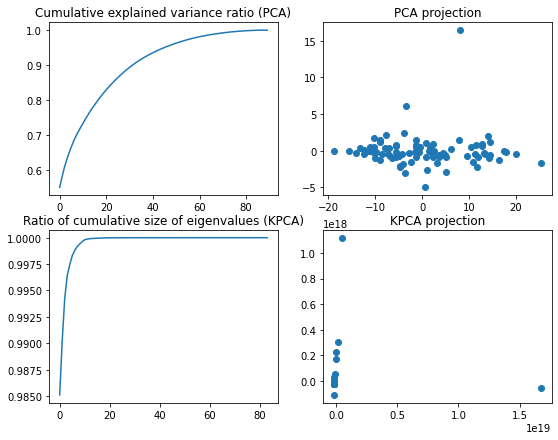

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.cluster
import sklearn.metrics
import matplotlib.cm as cm
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.manifold
%matplotlib inline
# PCA and kernel PCA projections and clustering

fig = plt.figure(figsize=(9,7))

# standardize data
X = sklearn.preprocessing.StandardScaler().fit_transform(centdata)

# linear PCA
pca = sklearn.decomposition.PCA()
pca.fit(X)
ax1 = fig.add_subplot(221)
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax1.set_title("Cumulative explained variance ratio (PCA)")

# 2D-projection of linear PCA
pca = sklearn.decomposition.PCA(n_components=2)
Xt = pca.fit_transform(X)
ax2 = fig.add_subplot(222)
ax2.scatter(Xt[:,0], Xt[:,1])
ax2.set_title("PCA projection")

# 10-degree polynomial PCA
pca = sklearn.decomposition.KernelPCA(kernel="poly", degree=10, gamma=10)
pca.fit(X)
ax3 = fig.add_subplot(223)
ax3.plot(np.cumsum(pca.lambdas_)/np.sum(pca.lambdas_))
ax3.set_title("Ratio of cumulative size of eigenvalues (KPCA)")

# 2D-projection of polynomial PCA
pca = sklearn.decomposition.KernelPCA(n_components=2, kernel="poly", degree=10, gamma=10)
Xt = pca.fit_transform(X)
ax4 = fig.add_subplot(224)
ax4.scatter(Xt[:,0], Xt[:,1])
ax4.set_title("KPCA projection");

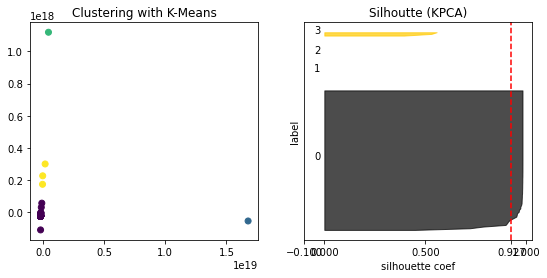

In [24]:
kmeans = sklearn.cluster.KMeans(n_clusters=4)
lab = kmeans.fit_predict(Xt)

fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(121)
ax1.scatter(Xt[:,0], Xt[:,1], c=lab)
ax1.set_title("Clustering with K-Means")

# large silhouette score but not useful since cluster 1 and 2 each only contain 1 data point
ax2 = fig.add_subplot(122)
plot_silhouette(Xt, lab, ax2)
ax2.set_title("Silhoutte (KPCA)");

<IPython.core.display.Javascript object>


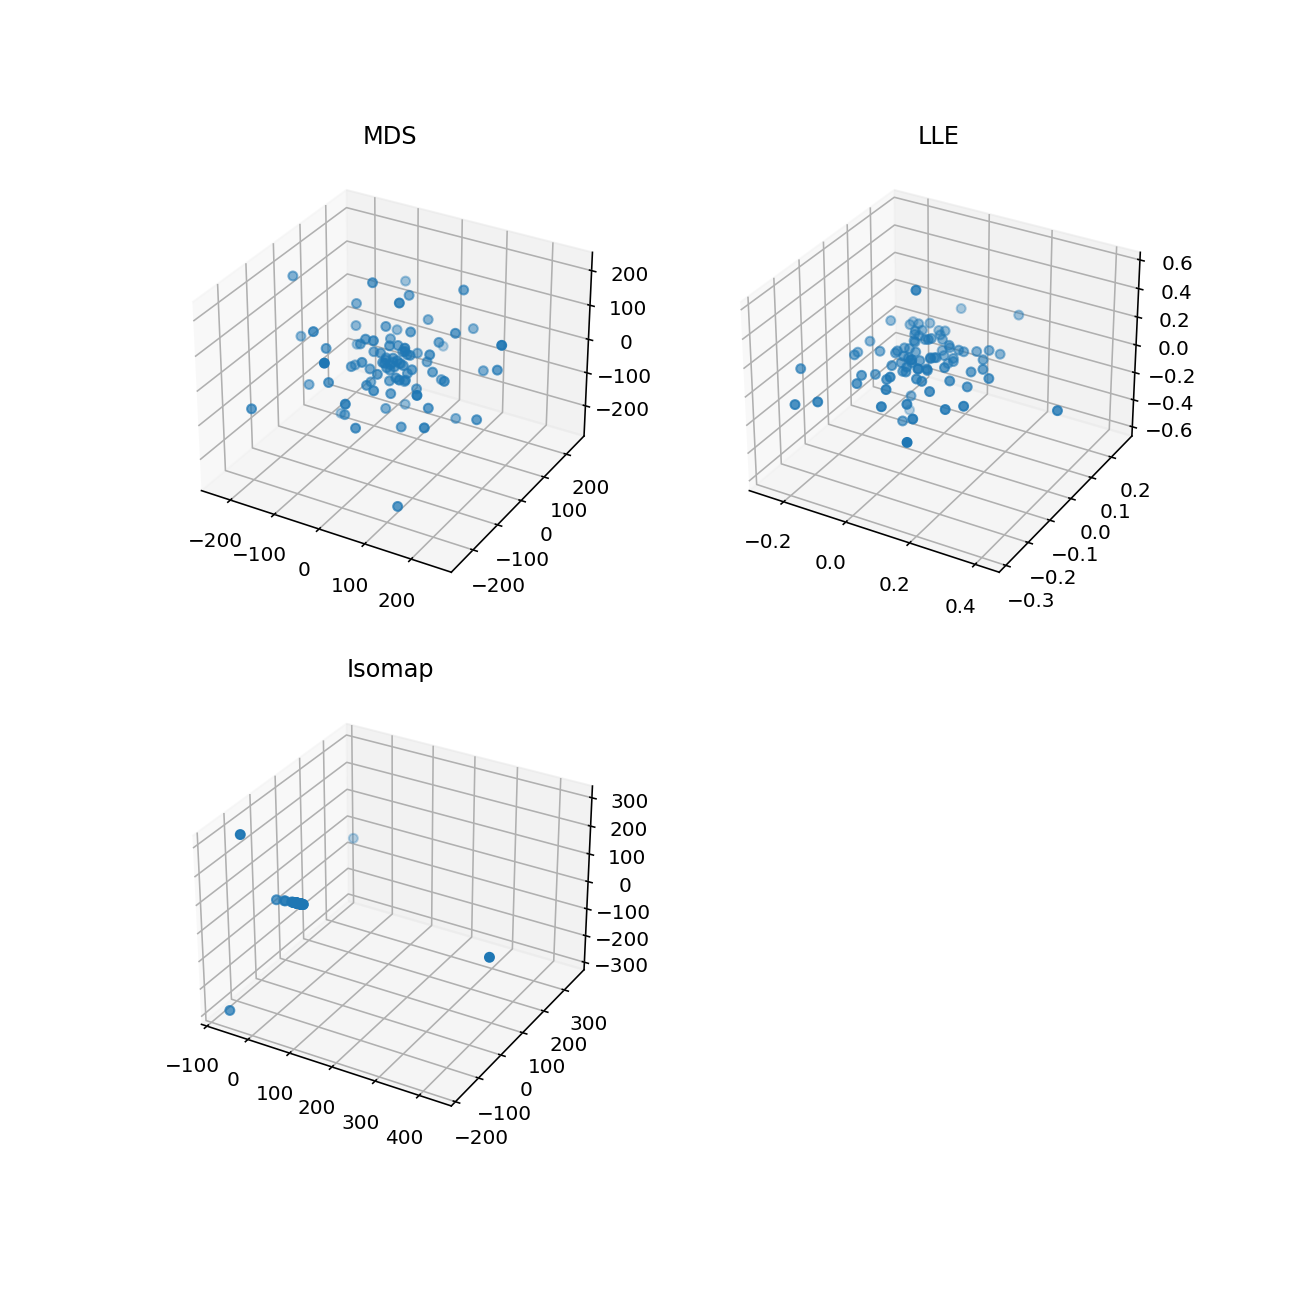

Text(0.5, 0.92, 'Isomap')

In [26]:
%matplotlib notebook
# non-linear manifold projections

fig = plt.figure(figsize=(9,9))

# multi-dimensional scaling
# data is clustered at a core. the further it is from the core, the sparser the data
mds = sklearn.manifold.MDS(n_components=3)
Xt1 = mds.fit_transform(data)
ax1 = fig.add_subplot(221, projection="3d")
ax1.scatter(Xt1[:,0], Xt1[:,1], Xt1[:,2])
ax1.set_title("MDS")


# local linear embedding
# data follows a trail that goes down -> up -> down
lle = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=3, n_components=3)
Xt2 = lle.fit_transform(data)
ax2 = fig.add_subplot(222, projection="3d")
ax2.scatter(Xt2[:,0], Xt2[:,1], Xt2[:,2])
ax2.set_title("LLE")

# isomap
# projection looks like a spiral, though its not exactly obvious
iso = sklearn.manifold.Isomap(n_neighbors=3, n_components=3)
Xt3 = iso.fit_transform(data)
ax3 = fig.add_subplot(223, projection="3d")
ax3.scatter(Xt3[:,0], Xt3[:,1], Xt3[:,2])
ax3.set_title("Isomap")

<IPython.core.display.Javascript object>


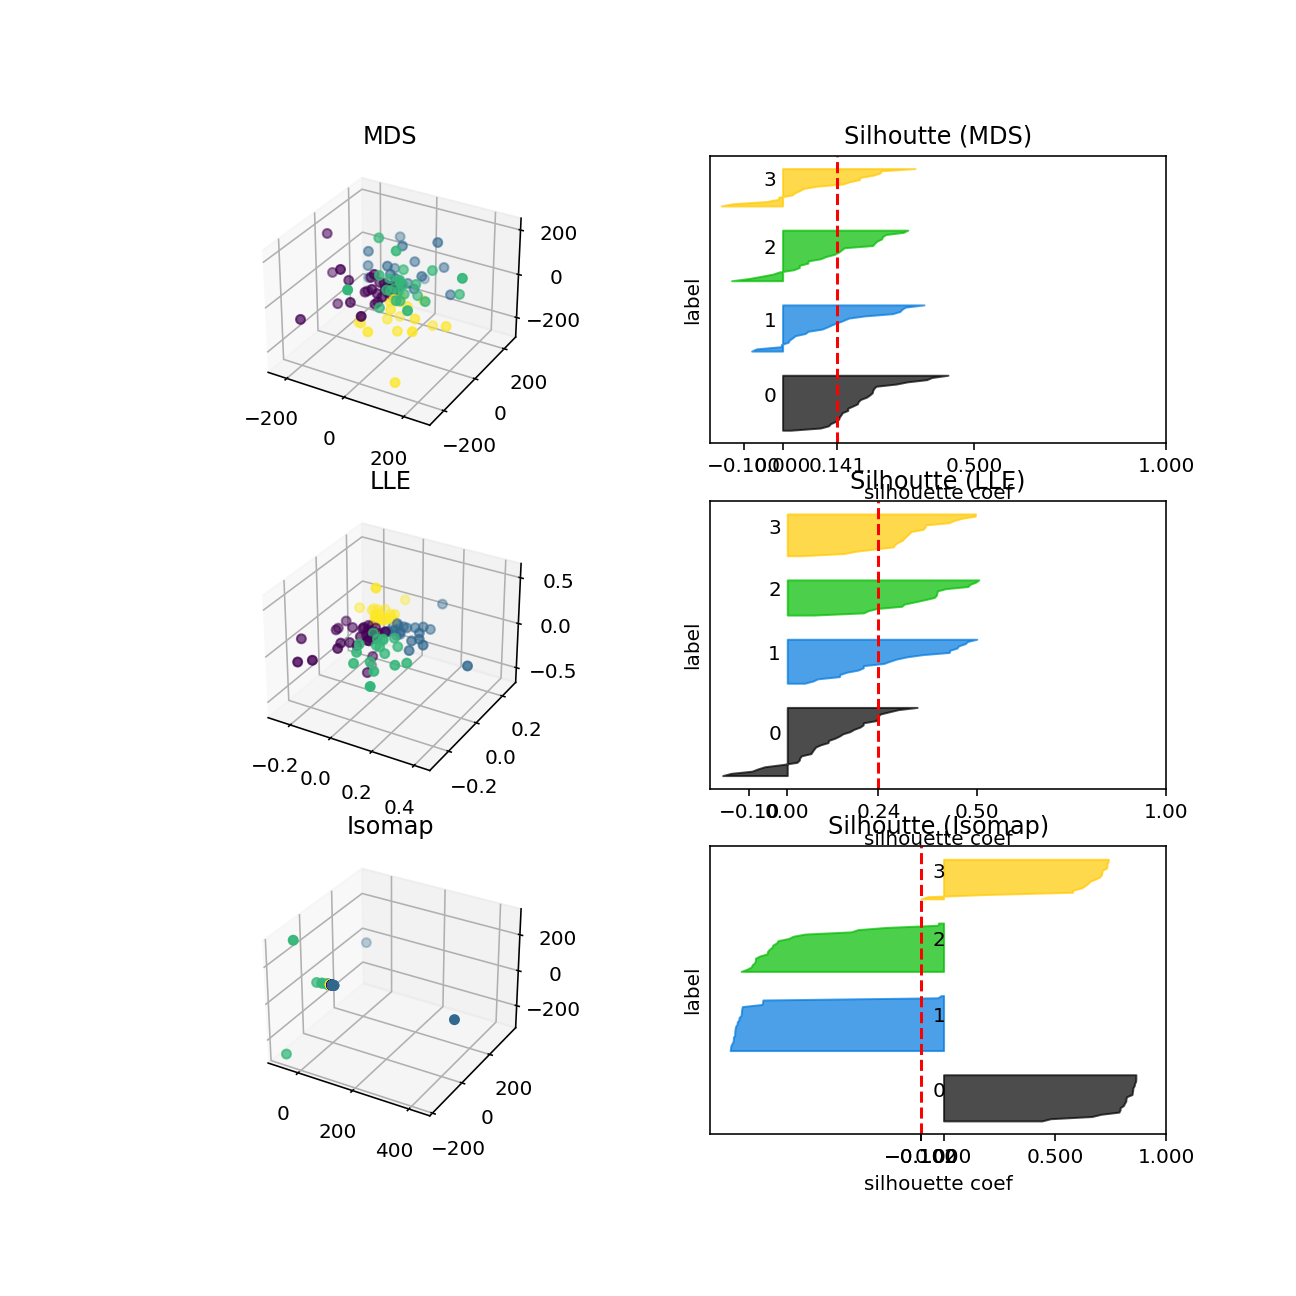

In [27]:
%matplotlib notebook

# spectral clustering on manifold projected data
fig = plt.figure(figsize=(9,9))

# mds
clustering = sklearn.cluster.SpectralClustering(n_clusters=4, affinity="nearest_neighbors")
lab1 = clustering.fit_predict(Xt1)
ax1 = fig.add_subplot(321, projection="3d")
ax1.scatter(Xt1[:,0], Xt1[:,1], Xt1[:,2], c=lab1)
ax1.set_title("MDS")
ax2 = fig.add_subplot(322)
plot_silhouette(Xt1, lab1, ax2)
ax2.set_title("Silhoutte (MDS)")

# lle
# produces best silhouette results (average score close to 0.6)
clustering = sklearn.cluster.SpectralClustering(n_clusters=4, affinity="nearest_neighbors")
lab2 = clustering.fit_predict(Xt2)
ax3 = fig.add_subplot(323, projection="3d")
ax3.scatter(Xt2[:,0], Xt2[:,1], Xt2[:,2], c=lab2)
ax3.set_title("LLE")
ax4 = fig.add_subplot(324)
plot_silhouette(Xt2, lab2, ax4)
ax4.set_title("Silhoutte (LLE)")

# isomap
clustering = sklearn.cluster.SpectralClustering(n_clusters=4, affinity="nearest_neighbors")
lab3 = clustering.fit_predict(Xt3)
ax5 = fig.add_subplot(325, projection="3d")
ax5.scatter(Xt3[:,0], Xt3[:,1], Xt3[:,2], c=lab3)
ax5.set_title("Isomap")
ax6 = fig.add_subplot(326)
plot_silhouette(Xt3, lab3, ax6)
ax6.set_title("Silhoutte (Isomap)");

In [28]:
"""
Attempt 3:

Working with short time fourier transform (STFT). This will return 2D-matrices for each
file. Results will be reshaped into 1D-vectors for data transformation and clustering.

Note: the parameter `hop_length` is set such that the STFT transformation of all files
return the same number of columns. In addition, working with the Minkowski distance with various `p` instead of 
the usual Euclidean distance.

"""
import librosa
import os
import warnings
import numpy as np

warnings.filterwarnings(action="ignore")

# get file path and files
filepath = "./Sound Track Data - STA142B/data/"
files = os.listdir(filepath)

# from exploratory data analysis, we find that:
# max data length is 661560
# min data length is 660984
# sampling rate (sr) is the same for all files at 22050
# number of audio files is 90

# declare variable to store all data
data = np.empty((0, 1025, 162))
sr = 22050
# store all music signals in data variable
for (i,file) in enumerate(files):
    file = "{0}.mp3".format(i)
    y,_ = librosa.load(os.path.join(filepath, file))
    # compute stft of music signal
    stft_ = librosa.stft(y, hop_length=4096)
    # store signal into data variable
    data = np.append(data, [stft_], axis=0)

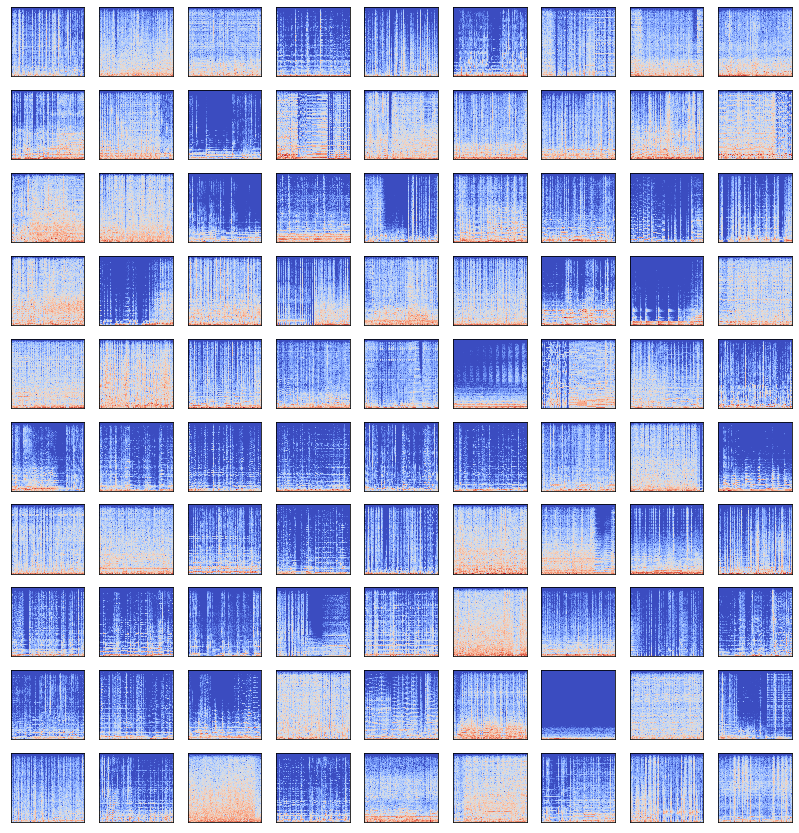

In [29]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# construct spectograms from stft
fig, ax = plt.subplots(10, 9, figsize=(14, 15))
for i in range(90):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(data[i,:,:])), ax=ax[i//9, i%9])

<IPython.core.display.Javascript object>


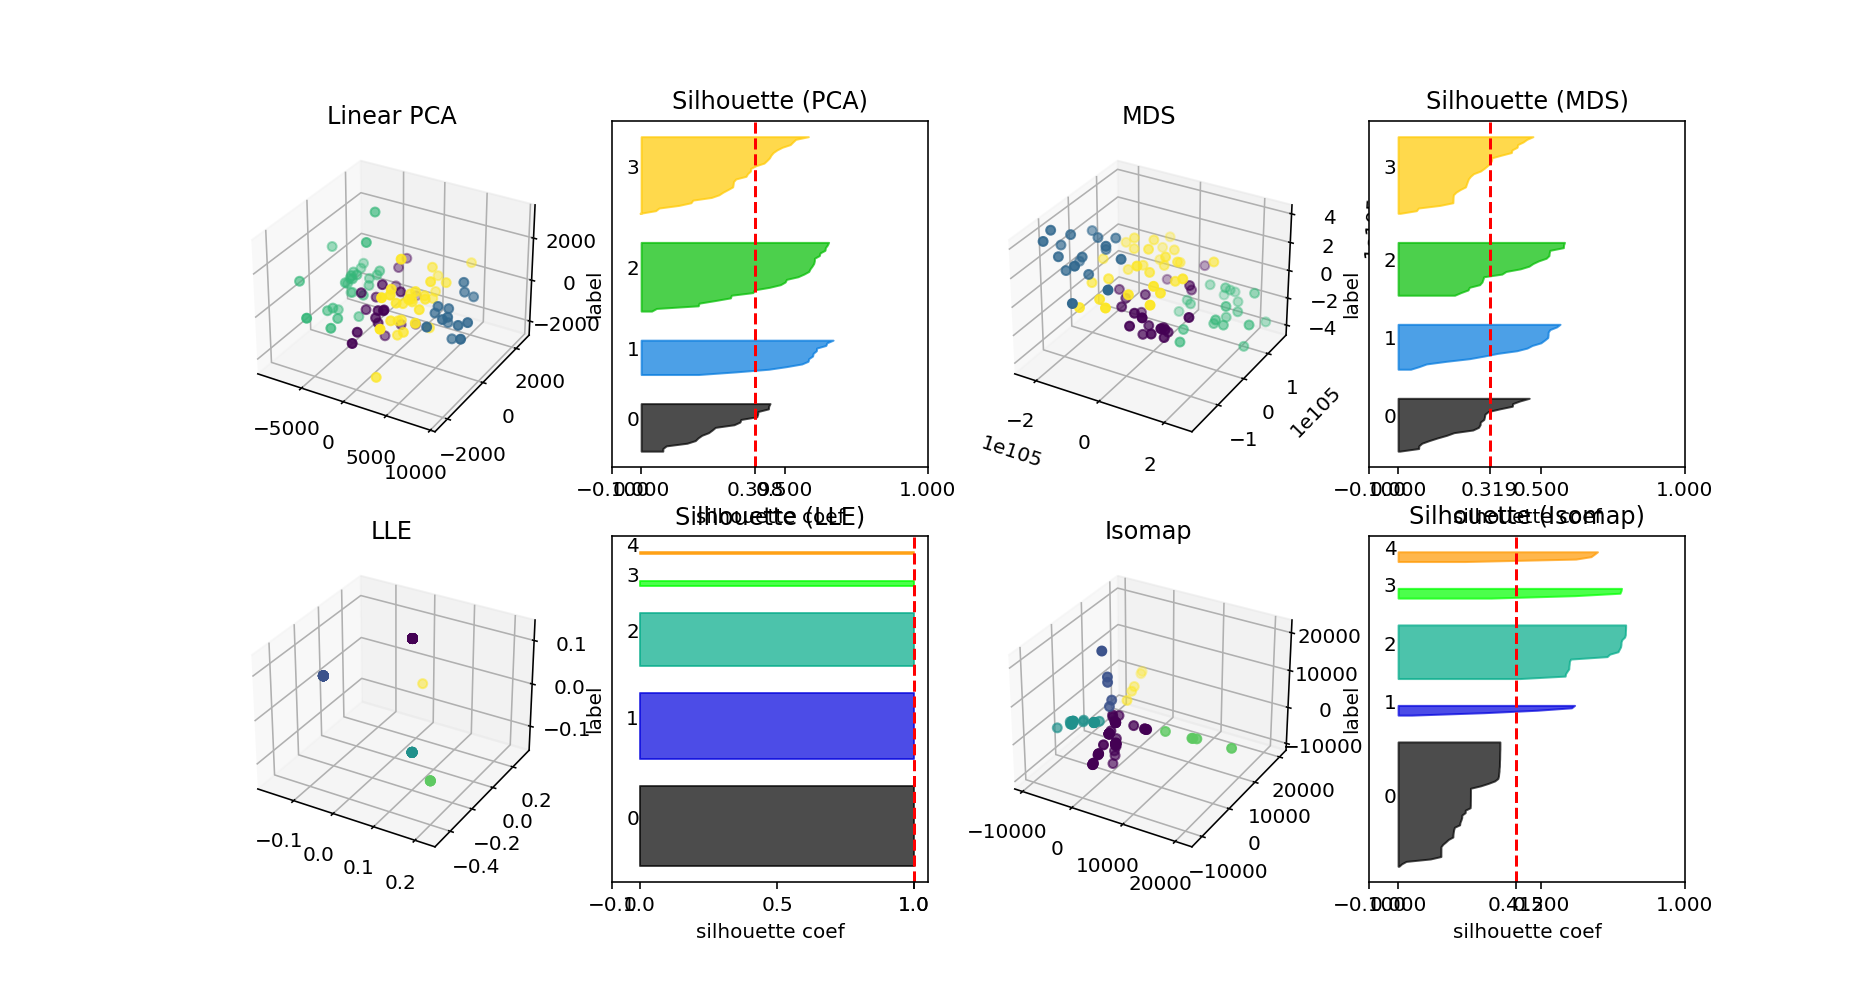

In [30]:
%matplotlib notebook
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import sklearn.manifold
import sklearn.decomposition
import sklearn.cluster

# reshape data into 1D-vectors
D = np.empty(data.shape)
for i in range(90):
    D[i,:,:] = librosa.amplitude_to_db(np.abs(data[i,:,:]))
X = D.reshape((90,-1))
# distance matrix
dist = squareform(pdist(X, "minkowski", p=0.05))

fig = plt.figure(figsize=(13,7))

# linear pca
pca = sklearn.decomposition.PCA(n_components=3)
Xt1 = pca.fit_transform(X)
kmean = sklearn.cluster.KMeans(n_clusters=4)
lab1 = kmean.fit_predict(Xt1)
ax1 = fig.add_subplot(241, projection="3d")
ax1.scatter(Xt1[:,0], Xt1[:,1], Xt1[:,2], c=lab1)
ax1.set_title("Linear PCA")
ax2 = fig.add_subplot(242)
plot_silhouette(Xt1, lab1, ax2)
ax2.set_title("Silhouette (PCA)")

# multi-dimensional scaling
mds = sklearn.manifold.MDS(n_components=3, dissimilarity="precomputed")
Xt2 = mds.fit_transform(dist)
kmean = sklearn.cluster.KMeans(n_clusters=4)
lab2 = kmean.fit_predict(Xt2)
ax3 = fig.add_subplot(243, projection="3d")
ax3.scatter(Xt2[:,0], Xt2[:,1], Xt2[:,2], c=lab2)
ax3.set_title("MDS")
ax4 = fig.add_subplot(244)
plot_silhouette(Xt2, lab2, ax4)
ax4.set_title("Silhouette (MDS)")

# local linear embedding
# setting n_neighbors=1/2/3 gives very good results(?)
lle = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=1, n_components=4)
Xt3 = lle.fit_transform(X)
kmean = sklearn.cluster.KMeans(n_clusters=5)
lab3 = kmean.fit_predict(Xt3)
ax5 = fig.add_subplot(245, projection="3d")
ax5.scatter(Xt3[:,0], Xt3[:,1], Xt3[:,2], c=lab3)
ax5.set_title("LLE")
ax6 = fig.add_subplot(246)
plot_silhouette(Xt3, lab3, ax6)
ax6.set_title("Silhouette (LLE)")

# isomap
iso = sklearn.manifold.Isomap(n_neighbors=1, n_components=3)
Xt4 = iso.fit_transform(X)
kmean = sklearn.cluster.KMeans(n_clusters=5)
lab4 = kmean.fit_predict(Xt4)
ax7 = fig.add_subplot(247, projection="3d")
ax7.scatter(Xt4[:,0], Xt4[:,1], Xt4[:,2], c=lab4)
ax7.set_title("Isomap")
ax8 = fig.add_subplot(248)
plot_silhouette(Xt4, lab4, ax8)
ax8.set_title("Silhouette (Isomap)");